In [1]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('../..'))))

import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from src.models.feature.GooLeNet import GoogLeNet
from src.models.feature.ResNet import ResNet18
from src.models.module.pooling import GVAP, GAP
from torch.nn import functional as F

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = 'cpu'
    torch.set_default_tensor_type('torch.FloatTensor')

class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#class_name = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

In [3]:
model = ResNet18(alpha=1, cal='mul').to(device)

model.load_state_dict(torch.load('./log/resnet18_cifar10_gvap_model_mul_10.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [4]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Block1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
      (relu2): ReLU()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1):

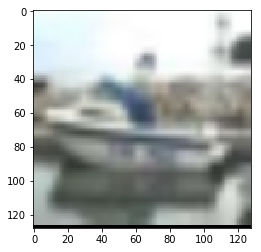

In [5]:
img_path = './test_img/cifar10/test.png'

img = Image.open(img_path)

plt.imshow(img)

target_class = 5

In [6]:
import torchvision.transforms as transforms
from torch.autograd import Variable

cvt_tensor = transforms.Compose([transforms.Resize((128,128)),
                                 transforms.ToTensor(),])
                                 #transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])
                                 
tensor_img = cvt_tensor(img).to(device)

tensor_img = tensor_img.view(1, 3, 128, 128)

tensor_img = Variable(tensor_img, requires_grad=True)

In [7]:
gradients = None

def hook_function(module, grad_input, grad_output):
    global gradients
    
    gradients = grad_input[0]

first_layer = list(model._modules.items())[0][1]
first_layer.register_backward_hook(hook_function)

In [8]:
forward_relu_outputs = []

def relu_backward_hook_function(module, grad_input, grad_output):
    global forward_relu_outputs
    
    corresponding_forward_output = forward_relu_outputs[-1]
    
    corresponding_forward_output[corresponding_forward_output > 0] = 1
    modified_grad_out = corresponding_forward_output * torch.clamp(grad_input[0], min=0.0)
    del forward_relu_outputs[-1]  # Remove last forward output
    return (modified_grad_out,)
    
def relu_forward_hook_function(module, input, output):
    global forward_relu_outputs
    
    forward_relu_outputs.append(output)
    
from torch.nn import ReLU
from torch.nn import Sequential

for pos, module in model._modules.items():
    if isinstance(module, ReLU):
        module.register_backward_hook(relu_backward_hook_function)
        module.register_forward_hook(relu_forward_hook_function)
    if isinstance(module, Sequential):
        for _, module in module._modules.items():
            for _, module in module._modules.items():
                if isinstance(module, ReLU):
                    module.register_backward_hook(relu_backward_hook_function)
                    module.register_forward_hook(relu_forward_hook_function)

In [9]:
output = model(tensor_img).to(device)

In [10]:
model.zero_grad()

In [11]:
one_hot_output = torch.cuda.FloatTensor(1, output.size()[-1]).zero_()
one_hot_output[0][target_class] = 1

In [12]:
output.backward(gradient=one_hot_output)

In [13]:
gradient = gradients.cpu().data.numpy()[0]
color_img = gradient.copy()

In [14]:
def scaling(img):
    img = img - np.min(img)
    img = img / np.max(img)
    
    return img

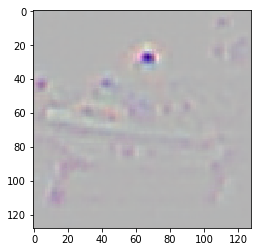

In [15]:
color_img = scaling(color_img)

color_img = color_img.transpose(1,2,0)

plt.imshow(color_img)

In [16]:
# convert grayscale
grayscale_im = np.sum(np.abs(gradient), axis=0)

im_max = np.percentile(grayscale_im, 99)
im_min = np.min(grayscale_im)

grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
grayscale_im = np.expand_dims(grayscale_im, axis=0)

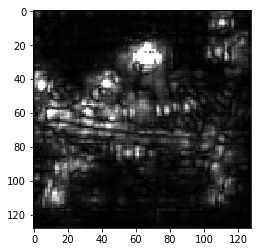

In [17]:
grayscale_im = scaling(grayscale_im)

# channel 1 -> 3
grayscale_im = np.repeat(grayscale_im, 3, axis=0)
grayscale_im = (grayscale_im * 255.0).astype('uint8')

grayscale_im = grayscale_im.transpose(1,2,0)

plt.imshow(grayscale_im)

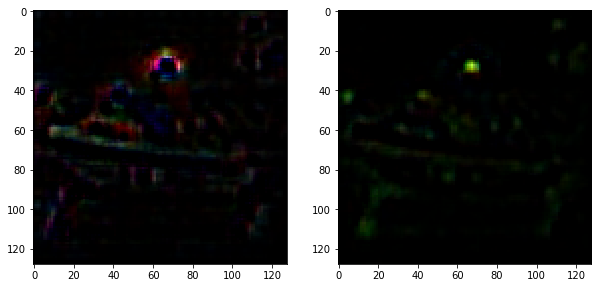

In [18]:
pos_saliency = (np.maximum(0, gradient) / gradient.max())
neg_saliency = (np.maximum(0, -gradient) / -gradient.min())

fig, axs = plt.subplots(1, 2, figsize=(10,10))

pos_saliency -= pos_saliency.min()
pos_saliency /= pos_saliency.max()

pos_saliency = pos_saliency.transpose(1,2,0)

axs[0].imshow(pos_saliency)

neg_saliency -= neg_saliency.min()
neg_saliency /= neg_saliency.max()

neg_saliency = neg_saliency.transpose(1,2,0)

axs[1].imshow(neg_saliency)